# Created filtered CSVs and static logo plots

In [1]:
# Imports 
import os
import warnings
import dmslogo
import pandas as pd
import seaborn as sns
import matplotlib.colors
import matplotlib.pyplot as plt

# Plotting colors
tol_muted_adjusted = [
    "#000000",
    "#CC6677", 
    "#1f78b4", 
    "#DDCC77", 
    "#117733", 
    "#882255", 
    "#88CCEE",
    "#44AA99", 
    "#999933", 
    "#AA4499", 
    "#DDDDDD",
]

# Create color palette
def color_gradient_hex(start, end, n):
    """Color function from polyclonal"""
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            name="_", colors=[start, end], N=n
        )
    return [matplotlib.colors.rgb2hex(tup) for tup in cmap(list(range(0, n)))]

# Seaborn style settings
sns.set(rc={
    "figure.dpi":300, 
    "savefig.dpi":300,
    "svg.fonttype":"none",
})
sns.set_style("ticks")
sns.set_palette(tol_muted_adjusted)

# Suppress warnings
warnings.simplefilter("ignore")

File paths for data:

In [2]:
# this cell is tagged as `parameters` for papermill parameterization
func_scores = None
antibody_escape_dir = None

filtered_csv_dir = None
escape_plots_dir = None

times_seen = None
n_selections = None
frac_models = None
cell_entry_default = None

filtered_func_scores = None

In [3]:
# # Uncomment for running interactive
# func_scores = "../results/func_effects/averages/293T_entry_func_effects.csv"
# antibody_escape_dir = "../results/antibody_escape/averages/"

# filtered_csv_dir = "../results/filtered_CSVs/"
# escape_plots_dir = "../results/escape_plots/"

# times_seen = 2
# n_selections = 8
# frac_models = 1
# cell_entry_default = -3

# filtered_func_scores = "../results/filtered_CSVs/293T_entry_filtered_mut_effects.csv"

Process antibody escape data and create both a filtered CSV file and antibody escape plot

In [4]:
# Initialize list of antibodies and sites for further analysis
GPC_A_akin_antibodies = [
    "S43711",
    "S44428",
    "S44446",
    "S44478",
]
GPC_A_akin_escape_sites = []

def get_filtered_csv_and_logo_plot(
    antibody_name,  
    func_effects_file, 
    min_times_seen, 
    min_func_score, 
    min_n_selections, 
    min_frac_models,
    filtered_file_dir = None,
    floor = False,
    sites = None,
    num_sites = 20,
    color_contact_sites = False,
    contacts_file = None,
    plots_dir = None,
    ax = [],
):
    """
    Function that filters and writes an antibody escape csv.
    Also creates summed escape profiles and logoplots.
    """

    # Load data
    escape_df = pd.read_csv(antibody_escape_dir+antibody_name+"_mut_effect.csv")
    func_effects = pd.read_csv(func_effects_file)

    # Create mutation column to match antibody df
    # **
    # Pipeline does not filter functional scores 
    # prior to filtering antibody selections
    # **
    func_effects["site"] = func_effects["site"].astype(str)
    func_effects["mutation"] = func_effects["wildtype"] + func_effects["site"] + func_effects["mutant"]
    func_scores_filter = func_effects.loc[func_effects["effect"] >= min_func_score]["mutation"].tolist()

    # Filter escape df for min times seen
    # min fraction of models, and no stop codons
    escape_df = (
        escape_df.loc[
            (escape_df["times_seen"] >= min_times_seen)
            &
            (escape_df["frac_models"] >= min_frac_models)
            &
            (escape_df["mutant"] != "*")
        ]
        .rename(columns={"escape_median" : "escape"})
        .reset_index(drop=True)
    )

    # Drop all but a few columns
    escape_df = escape_df[[
            "site", 
            "wildtype", 
            "mutant", 
            "mutation", 
            "escape",
    ]]

    # Mark mutations that are below functional cutoff
    # and replace measurements with NaN
    escape_df["poor_cell_entry"] = (
        escape_df["mutation"].apply(lambda x: False if x in func_scores_filter else True)
    )
    escape_df["escape"] = (
        escape_df.apply(lambda x: float("NaN") if (x["poor_cell_entry"] == True) else x["escape"], axis=1)
    )

    # Create a floored escape column
    escape_df["floored_escape"] = escape_df["escape"].clip(lower=0)

    # Write filtered escape to csv
    if filtered_file_dir != None:
        escape_df.to_csv(filtered_file_dir+antibody_name+"_filtered_mut_effects.csv", index=False)

    # Show only positive escape values
    if floor == True:
        escape_df["escape"] = escape_df["floored_escape"]

    # Add site escape column
    summed_df = (
        escape_df
        .groupby(["site", "wildtype"])
        .aggregate({
            "escape" : "sum",
        })
        .rename(columns={"escape" : "site_escape"})
        .reset_index()
    )
    escape_df = (
        escape_df.merge(
            summed_df,
            how="left",
            on=["site", "wildtype"],
            validate="many_to_one",
        )
    )
    
    # If not sites are given, then show top summed escape sites
    if sites == None:
        sites = sorted(summed_df.nlargest(num_sites, "site_escape")["site"].tolist())
        if antibody_name in GPC_A_akin_antibodies:
            GPC_A_akin_escape_sites.append(sorted(summed_df.nlargest(10, "site_escape")["site"].tolist()))
            

    # Mark escape sites for each antibody to show
    escape_df["show_site"] = escape_df.apply(lambda x: True if x["site"] in sites else False, axis=1)

    # Shade contact sites in logo plot
    if color_contact_sites == True:
        # **
        # Currently there are no known structures for these antibodies
        contacts_df = pd.read_csv(contacts_file)
        shade_sites = list(contacts_df.loc[contacts_df["distance"] == 4]["position"].unique())
        escape_df["shade_site"] = escape_df.apply(lambda x: "#DDCC77" if x["site"] in shade_sites else None, axis=1)
        # **
    else:
        escape_df["shade_site"] = None
    escape_df["shade_alpha"] = 0.35

    # Merge functional and escape dfs
    func_effects["site"] = func_effects["site"].astype("int")
    func_effects = func_effects.loc[func_effects["mutant"] != "*"] # remove stop codons
    func_effects["effect"] = func_effects["effect"].clip(upper=0, lower=(min_func_score + (min_func_score*0.05))) # clip scores 
    escape_df = (
        escape_df.merge(
            func_effects[[
                "site", 
                "wildtype", 
                "mutant", 
                "mutation",
                "effect",
            ]],
            how="left",
            on=["site", "wildtype", "mutant", "mutation"],
            validate="one_to_one",
        )
    )
    # Missing functional values are filled as min to make less visible
    escape_df["effect"] = escape_df["effect"].fillna(min_func_score + (min_func_score*0.05)) 
    
    # Add color column for logo plots
    func_color_map = dmslogo.colorschemes.ValueToColorMap(
        minvalue=func_effects["effect"].min(),
        maxvalue=func_effects["effect"].max(),
        cmap=matplotlib.colors.ListedColormap(color_gradient_hex("white", "#000000", n=20))
    )
    escape_df = (
        escape_df.assign(
            color=lambda x: x["effect"].map(func_color_map.val_to_color)
        )
    )

    # Add wildtype to each site for logo plot
    escape_df["wt_site"] = escape_df["wildtype"] + escape_df["site"].map(str)

    # Fill in missing sites because logo plot requires
    # a sequential list of sites
    seen_list = [False]*491
    for index in range(len(escape_df.index)):
        site = escape_df.at[index, "site"] - 1 
        seen_list[site] = True
    for index, seen in enumerate(seen_list):
        if seen == False:
            site = index + 1
            # Add missing sites
            escape_df.loc[len(escape_df.index)] = [
                site,
                "X",
                "X",
                "X"+str(site)+"X",
                float("nan"),
                False,
                float("nan"),
                float("nan"),
                False,
                None,
                0.35,
                min_func_score + (min_func_score*0.05),
                "#ffffff",
                "X"+str(site),
            ]

    # Sort by site
    escape_df = (
        escape_df
        .sort_values(by="site")
        .astype({"mutant" : "str"})
        .reset_index(drop=True)
    )

    # Create fig if no ax passed to function
    if len(ax) == 0:
        # Set figure size and subplots
        fig, axes = plt.subplots(
            1, 
            3, 
            gridspec_kw={"width_ratios":[1,3,0.1]},
            figsize=(12, 2.5), 
        )
        
        # Adjust spacing of subplots
        fig.subplots_adjust(
            wspace=0.3, 
            top=0.8,
            bottom=0.3,
        )

        # Plot escape profiles and logo plots
        # Lineplot
        _, lineplot = dmslogo.draw_line(
            escape_df,
            x_col="site",
            height_col="site_escape",
            show_col="show_site",
            ax=axes[0],
            show_color="#CC6677",
            linewidth=1,
        )
        # Logoplot
        _, logoplot = dmslogo.draw_logo(
            escape_df.query("show_site == True"),
            x_col="site",
            letter_col="mutant",
            letter_height_col="escape",
            ax=axes[1],
            xtick_col="wt_site",
            color_col="color",
            shade_color_col="shade_site",
            shade_alpha_col="shade_alpha",
            draw_line_at_zero="if_negative",
        )
    else:
        # Plot escape profiles and logo plots
        # Lineplot
        _, lineplot = dmslogo.draw_line(
            escape_df,
            x_col="site",
            height_col="site_escape",
            show_col="show_site",
            ax=ax[0],
            show_color="#CC6677",
            linewidth=1,
        )
        # Logoplot
        _, logoplot = dmslogo.draw_logo(
            escape_df.query("show_site == True"),
            x_col="site",
            letter_col="mutant",
            letter_height_col="escape",
            ax=ax[1],
            xtick_col="wt_site",
            color_col="color",
            shade_color_col="shade_site",
            shade_alpha_col="shade_alpha",
            draw_line_at_zero="if_negative",
        )

    # Format lineplot
    lineplot.set(ylabel="escape", xlabel=None)
    lineplot.set_xlim(1,491)
    xticks = [100, 200, 300, 400]
    lineplot.set_xticks(xticks)
    x_labels = [
        "100", 
        "200",
        "300",
        "400",
    ]
    lineplot.set_xticklabels(labels=x_labels, rotation=90, horizontalalignment="center")
    lineplot.set_title(
        antibody_name[0:4] + "." + antibody_name[4:], 
    )

    # Format logoplot
    logoplot.set(ylabel=None, xlabel=None)
    logoplot.set_title(
        "antibody " + antibody_name[0:4] + "." + antibody_name[4:], 
    )

    if len(ax) == 0:
        # Create color bar for func effects
        _, ax_scale = func_color_map.scale_bar(
            orientation="vertical", 
            ax=axes[2],
        )
    else:
        # Create color bar for func effects
        _, ax_scale = func_color_map.scale_bar(
            orientation="vertical", 
            ax=ax[2],
        )
        
    ax_scale.set_yticks([-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0])
    scale_labels = ["-3.0", "-2.5", "-2.0", "-1.5", "-1.0", "-0.5", "≥0"]
    ax_scale.set_yticklabels(labels=scale_labels)
    ax_scale.set_title("effect on\ncell entry")

    if plots_dir != None:
        fig.savefig(plots_dir + antibody_name + "_escape_plot.svg")

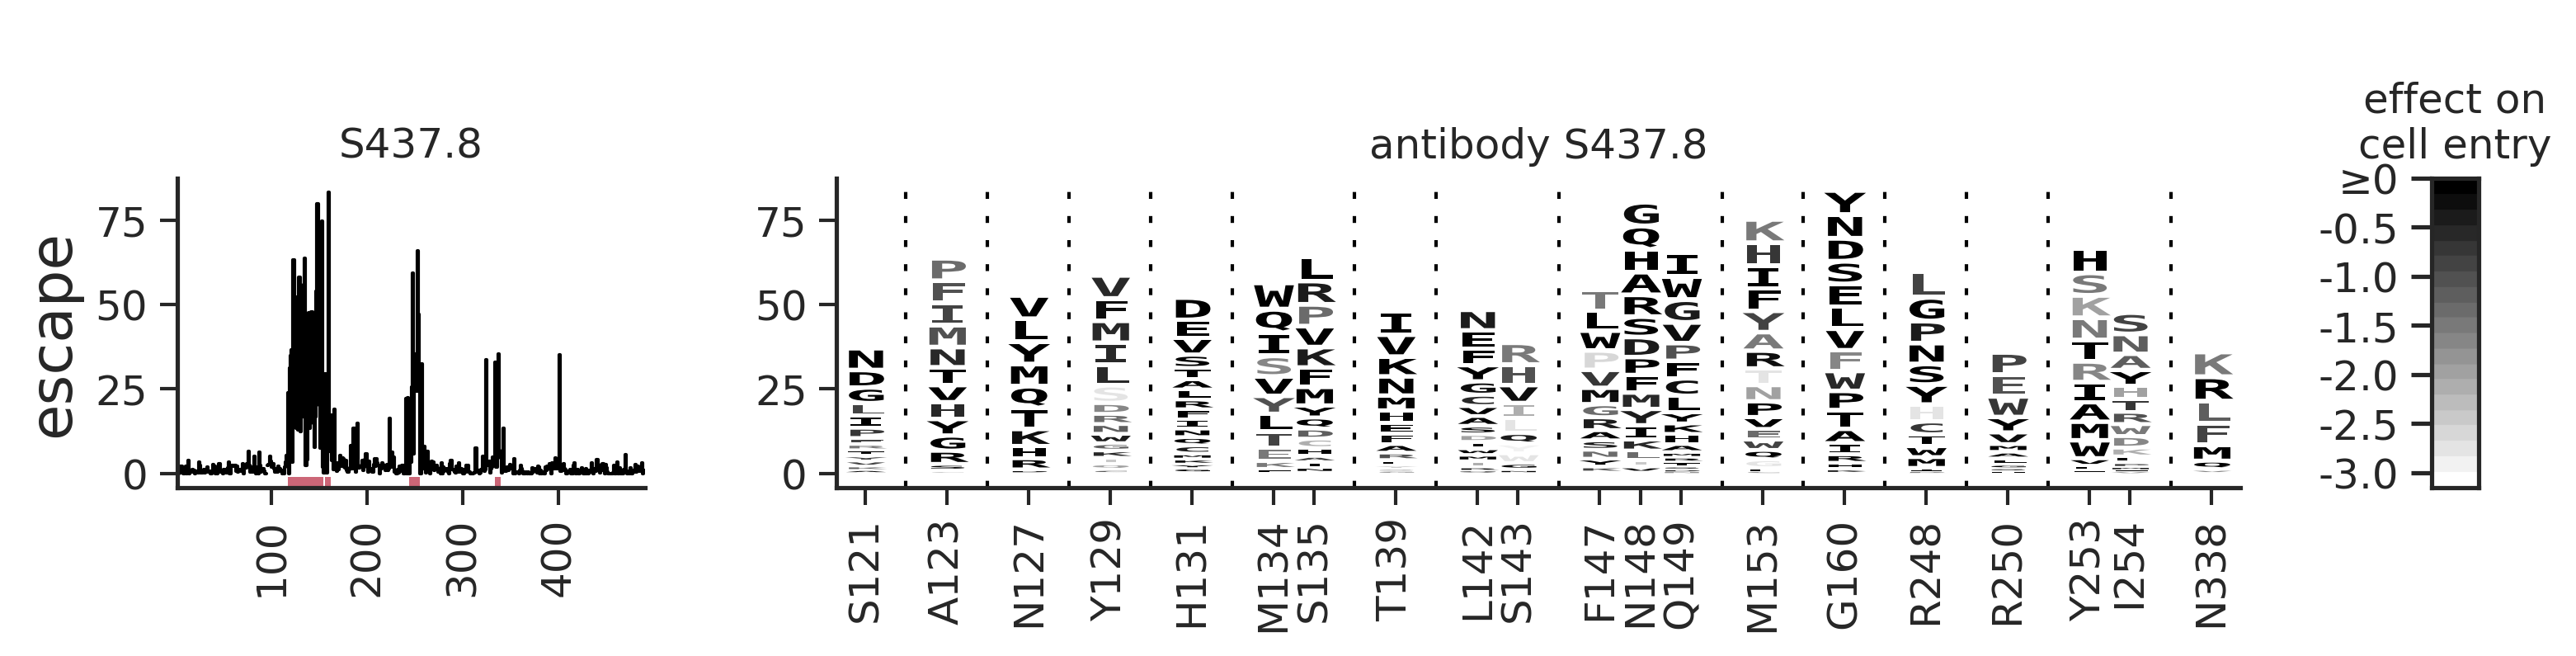

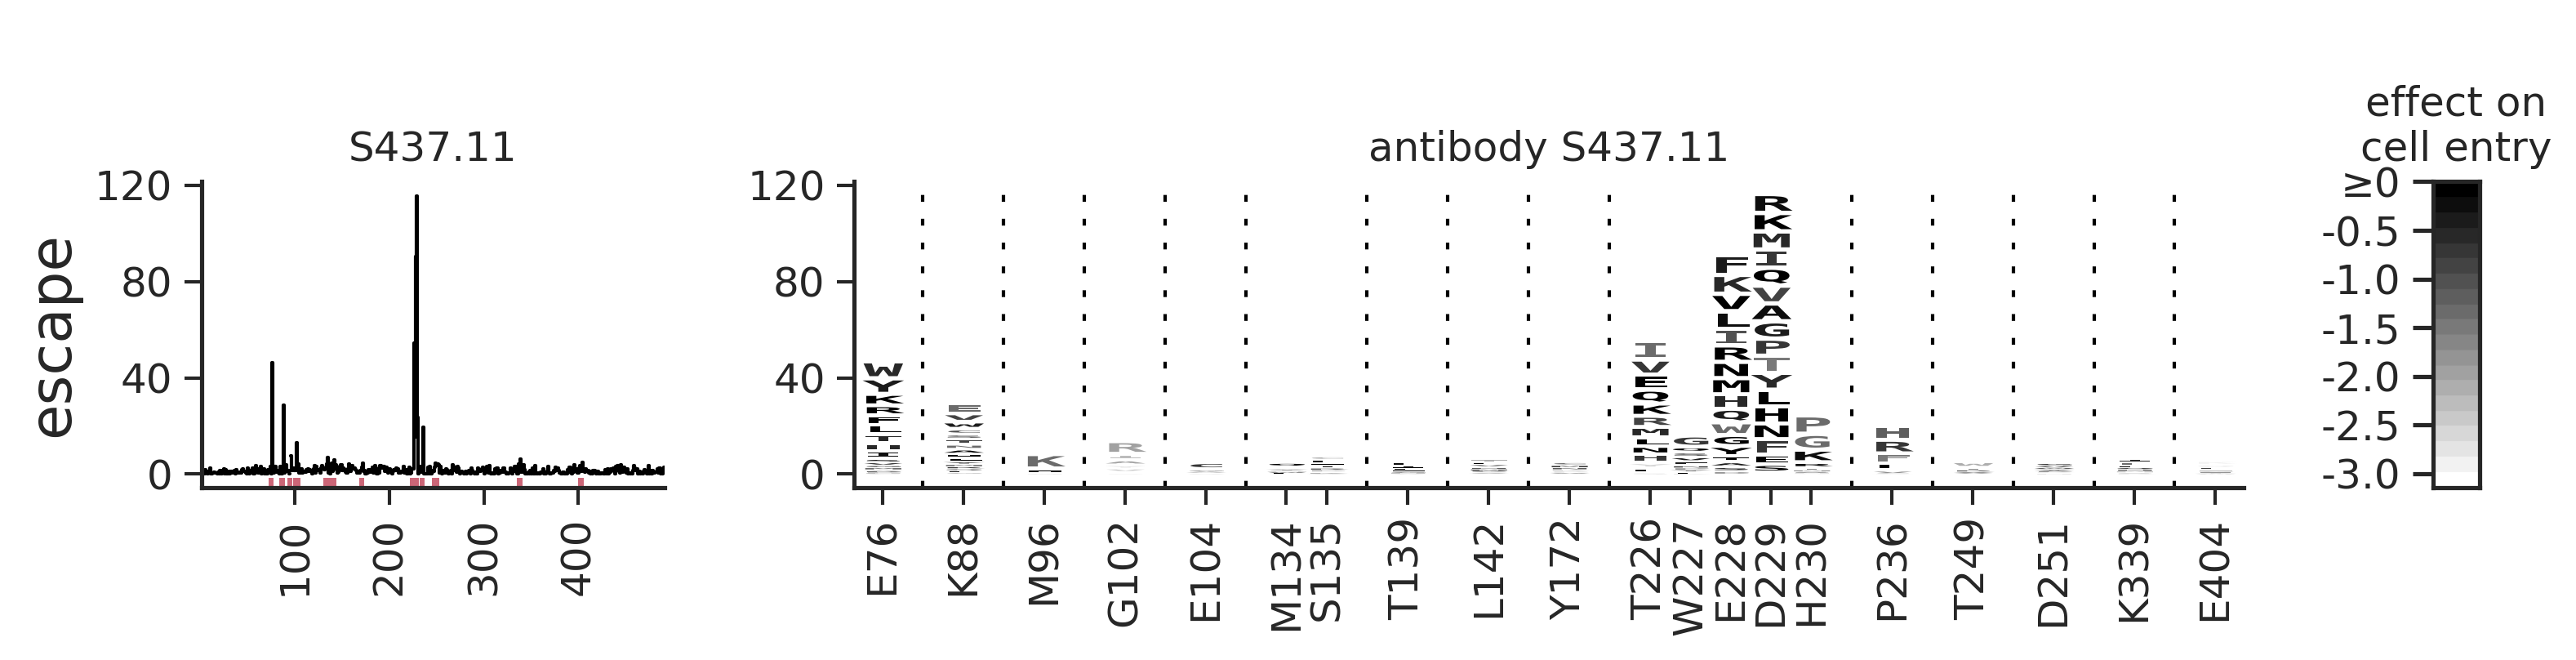

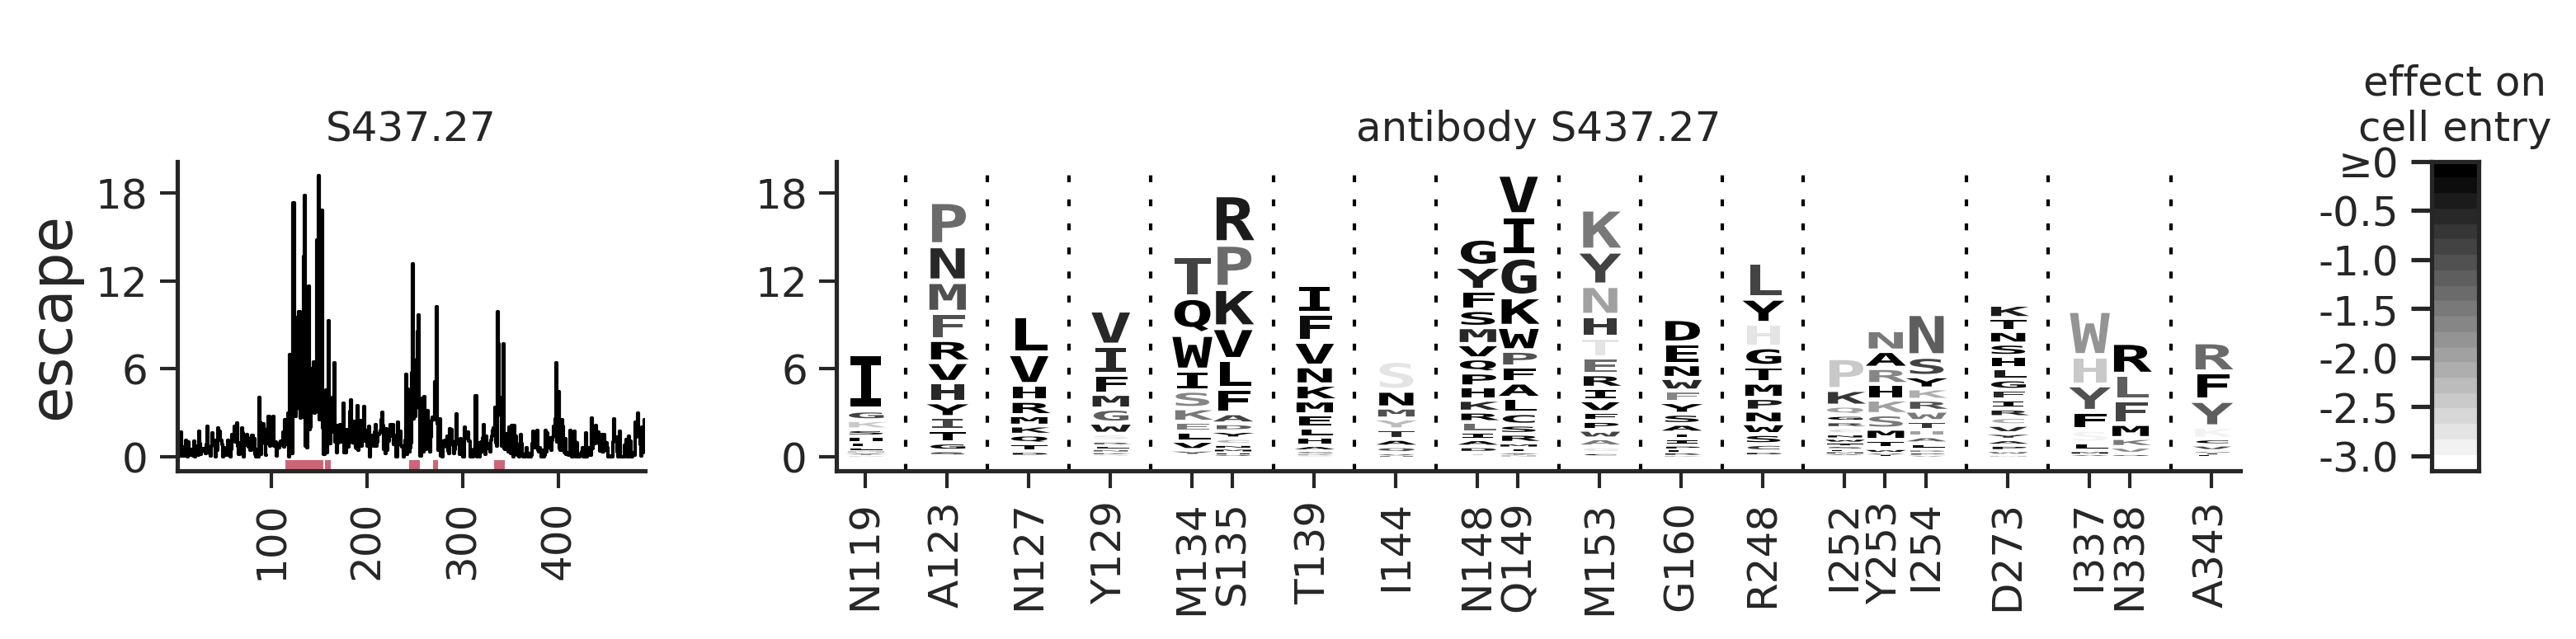

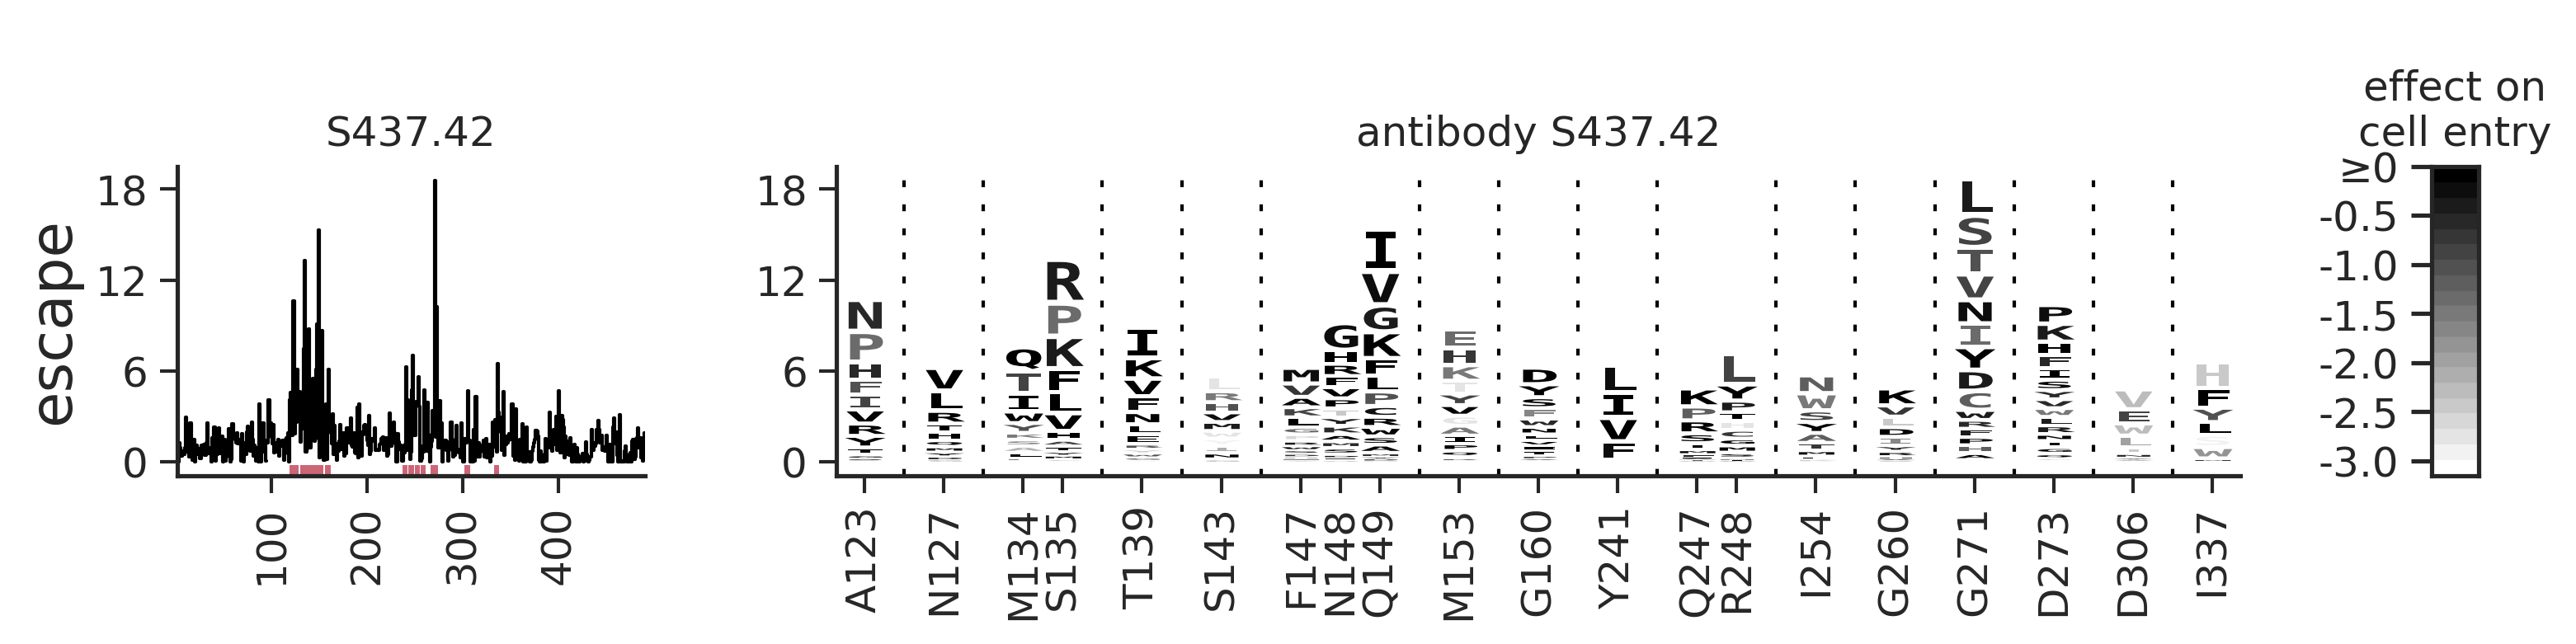

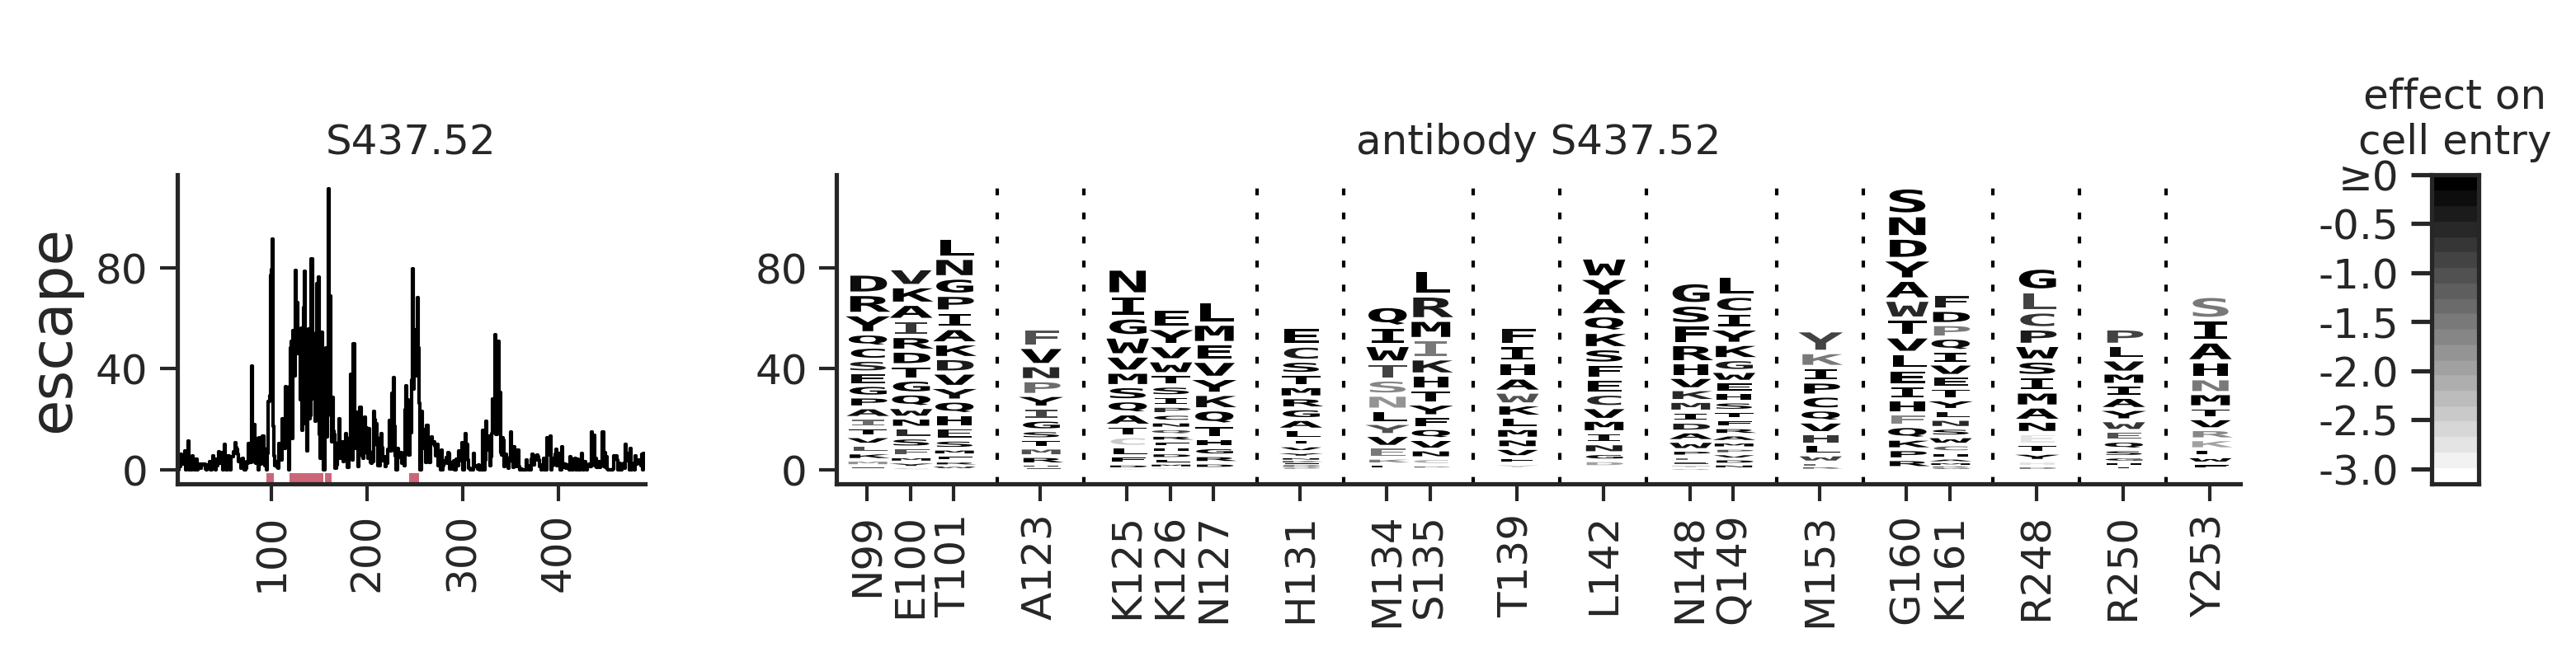

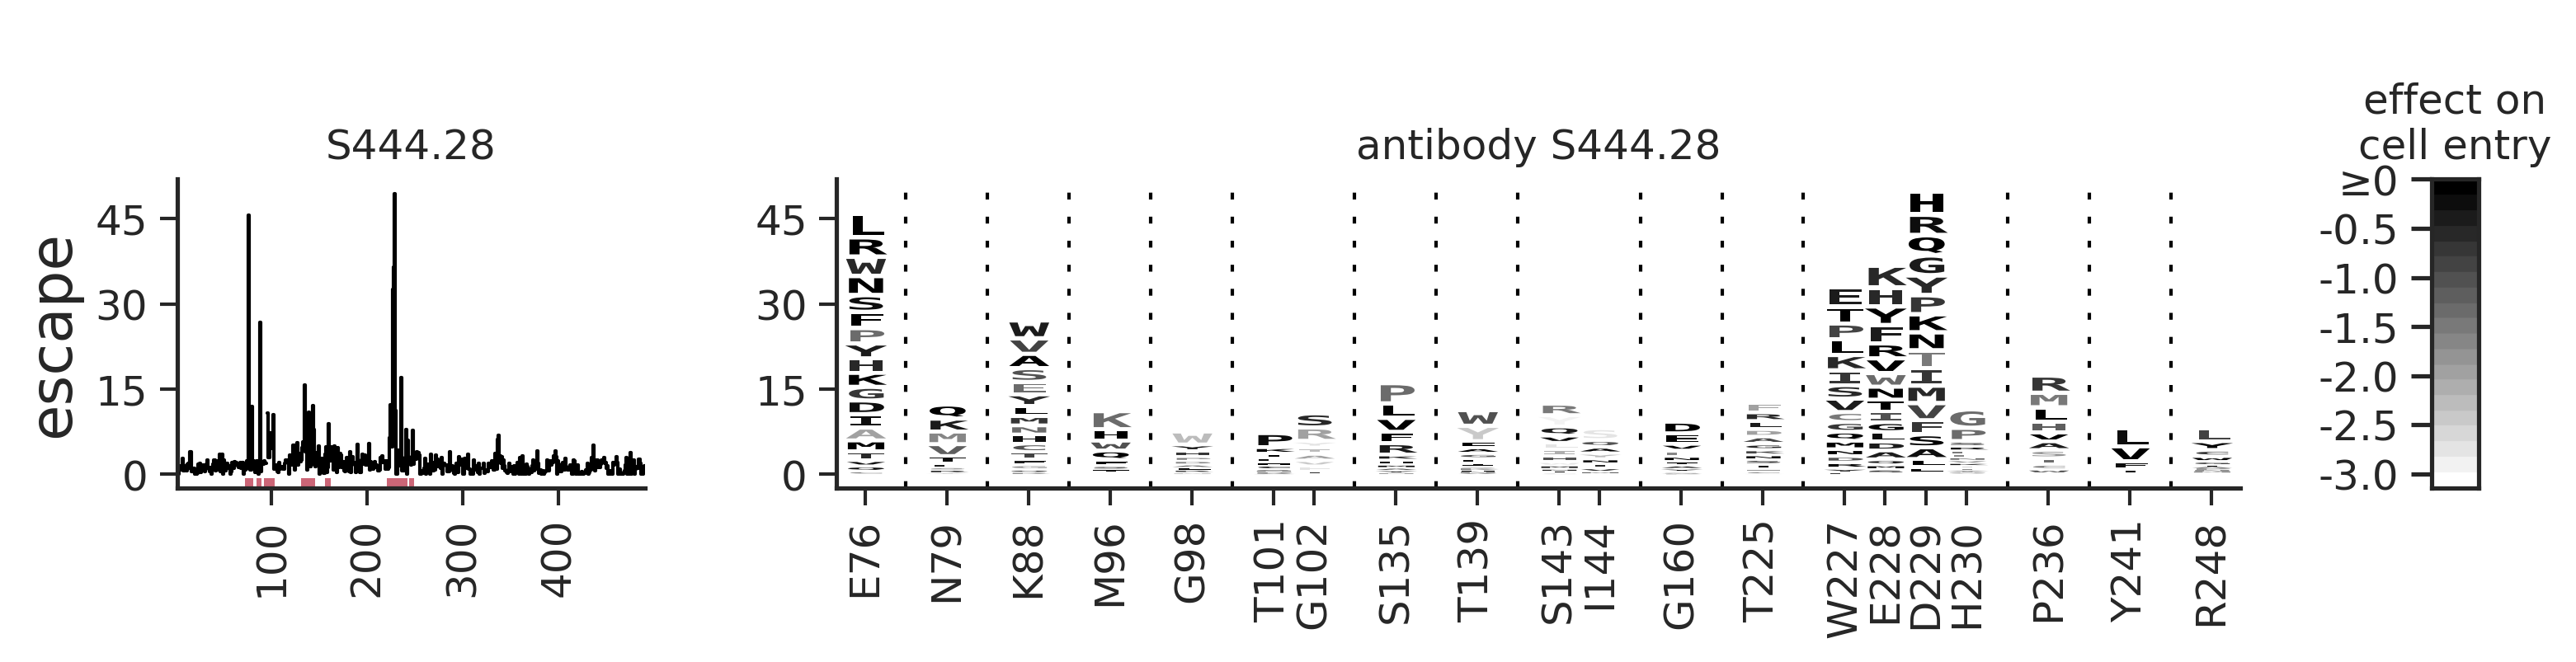

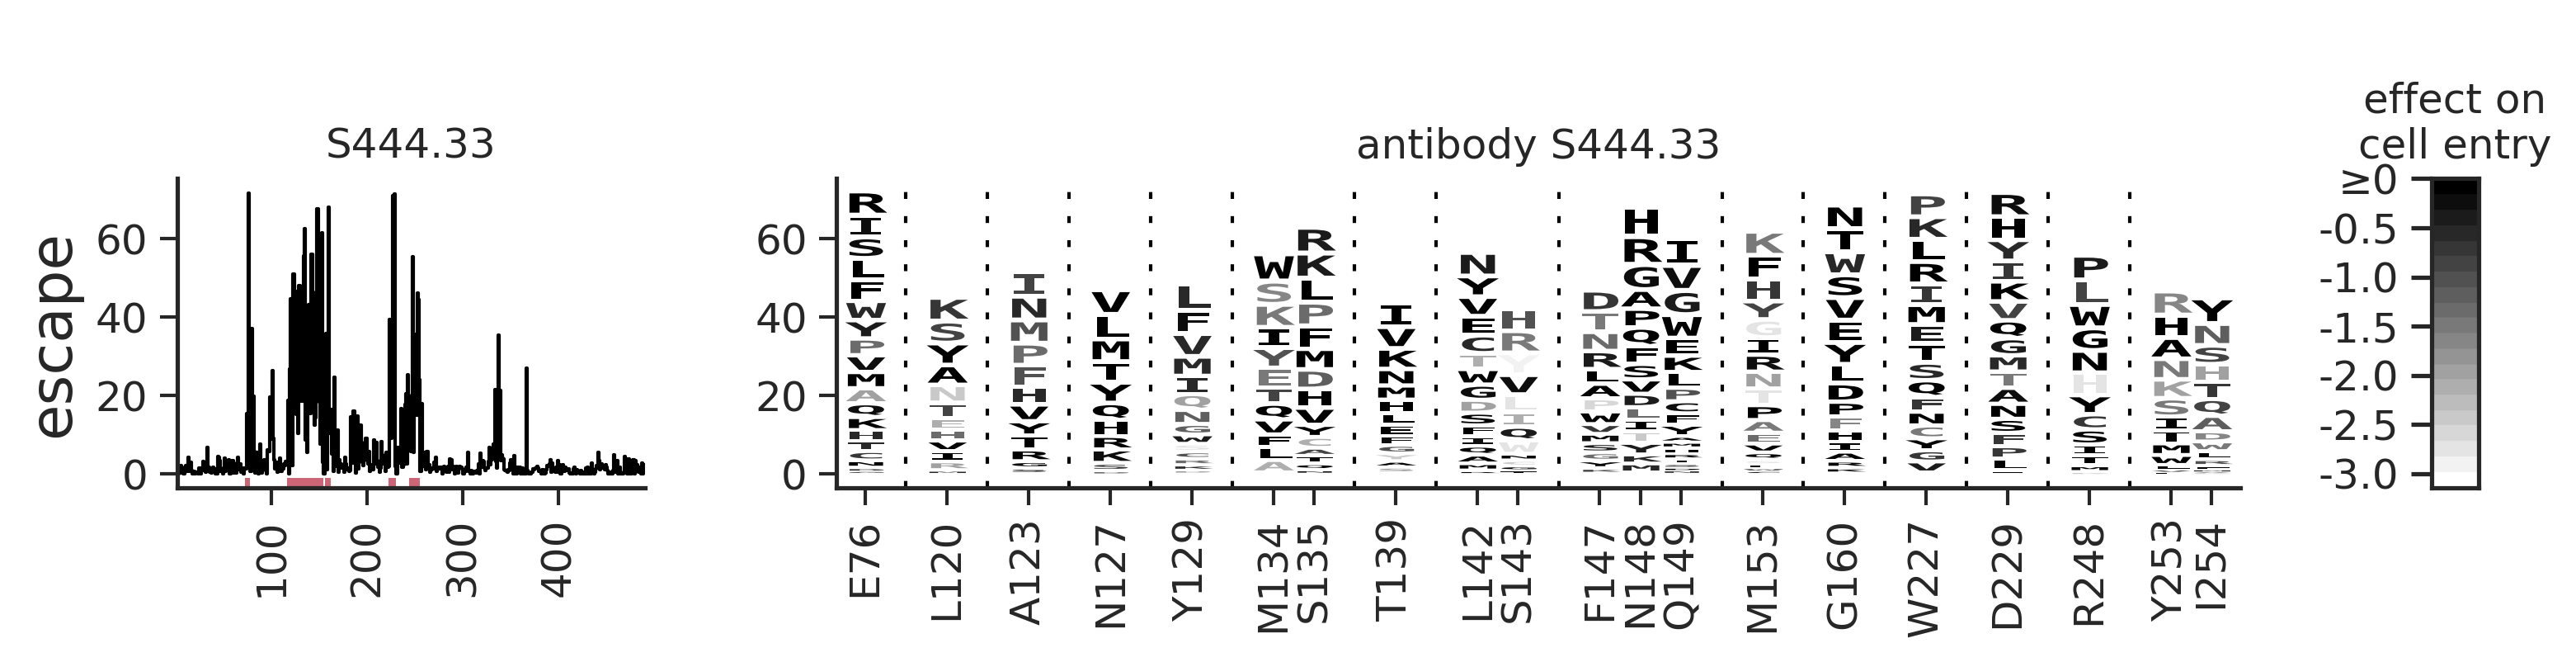

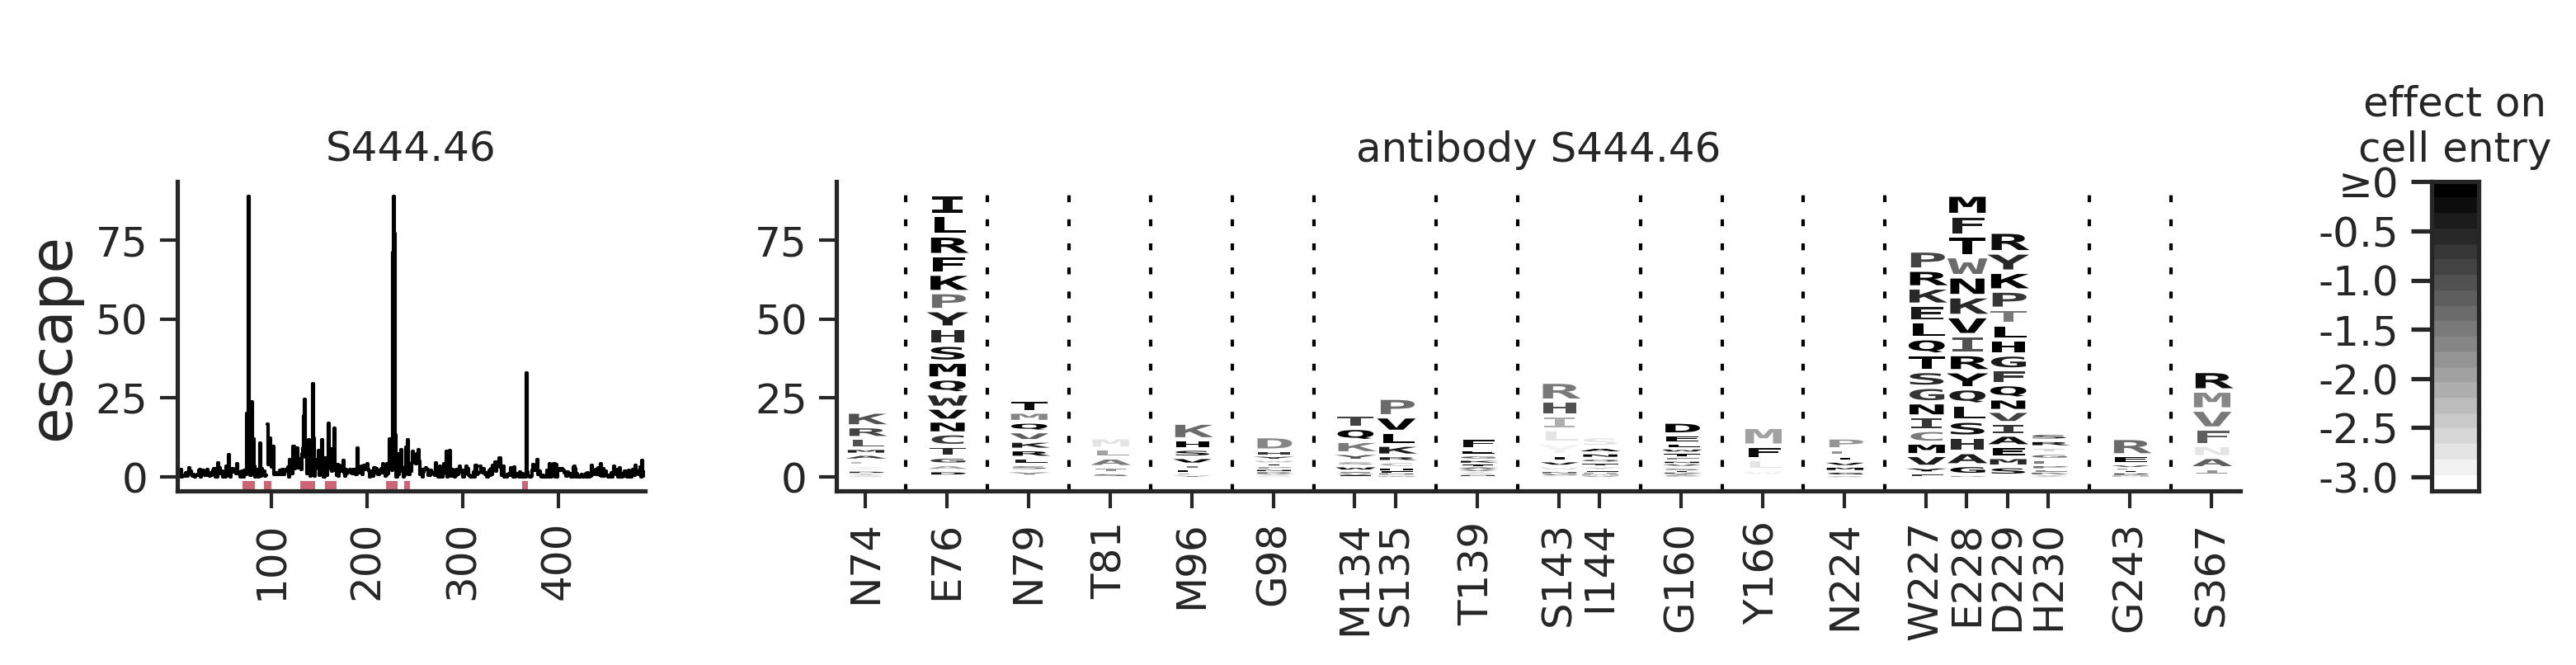

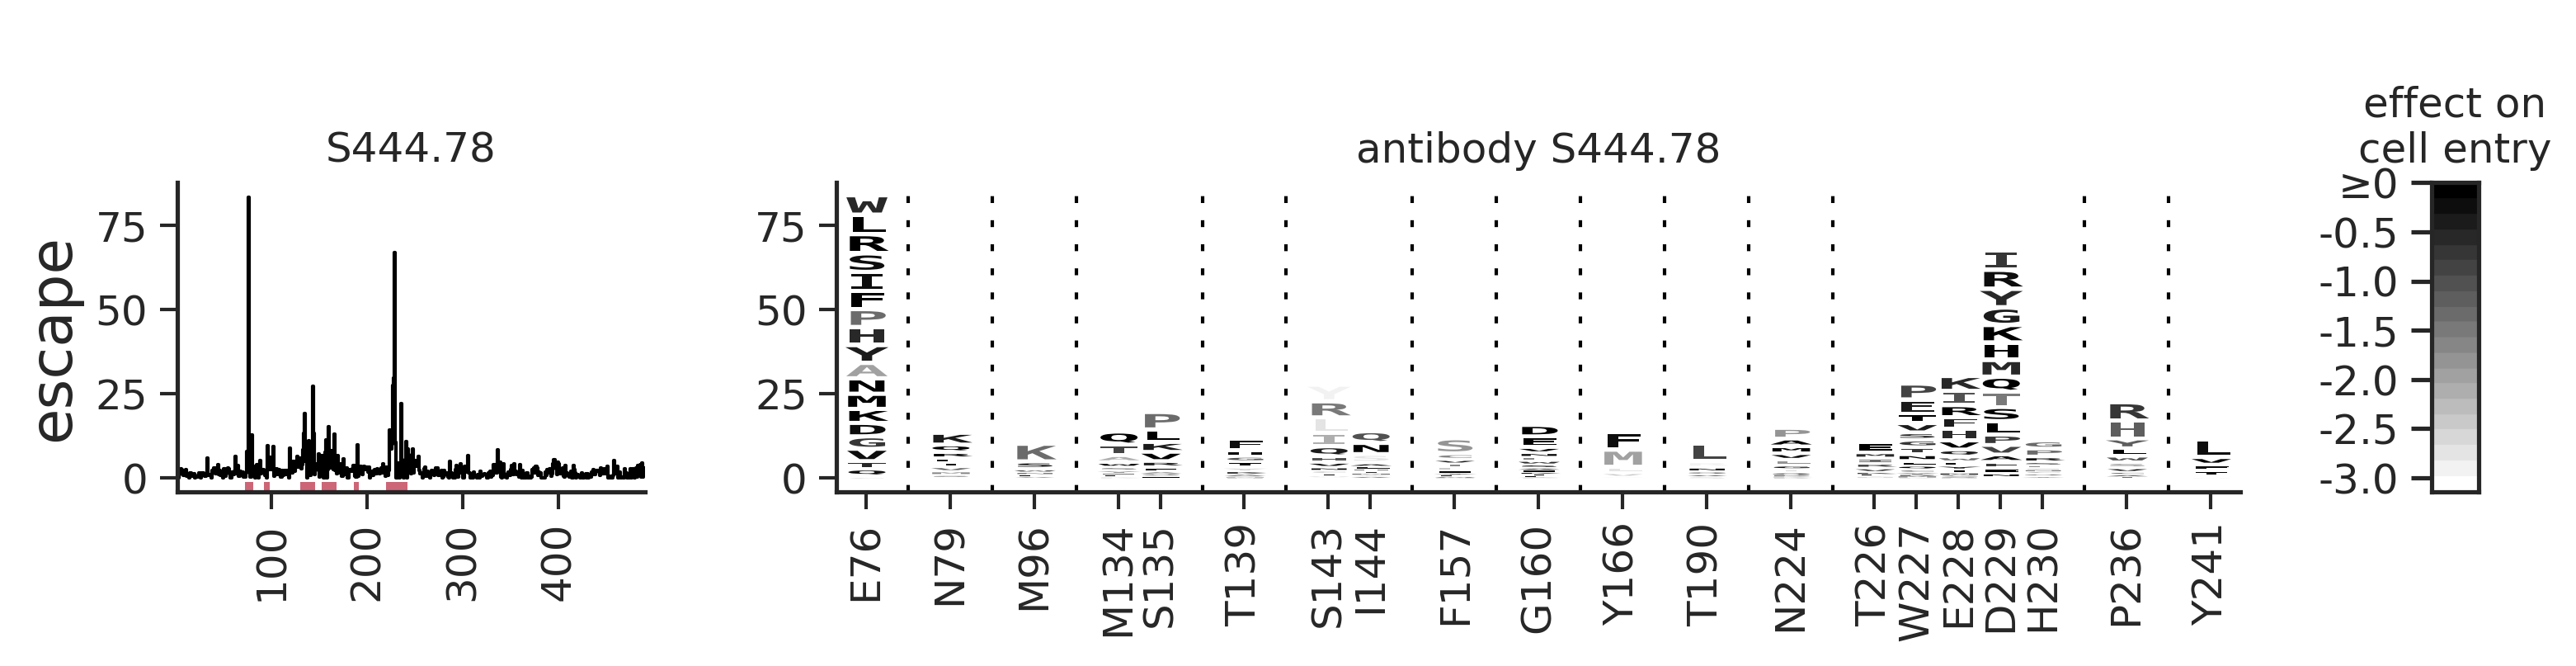

In [5]:
antibodies = [
    "S4378",
    "S43711",
    "S43720",
    "S43727",
    "S43742",
    "S43752",
    "S44428",
    "S44433",
    "S44446",
    "S44478",
]

for antibody in antibodies:

    # Make output dir if doesn't exist
    if not os.path.exists(filtered_csv_dir):
        os.mkdir(filtered_csv_dir)

    # Make output dir if doesn't exist
    if not os.path.exists(escape_plots_dir):
        os.mkdir(escape_plots_dir)
    
    get_filtered_csv_and_logo_plot(
        antibody,
        func_scores,
        times_seen,
        cell_entry_default,
        n_selections,
        frac_models,
        filtered_file_dir = filtered_csv_dir,
        floor = True,
        plots_dir = escape_plots_dir,
    )

Escape summary plot for GPC-A akin antibodies

Escape sites to show for GPC-A antibodies
[134, 135, 143, 144, 160, 74, 76, 79, 88, 96, 225, 226, 227, 228, 229, 102, 230, 224, 236, 367]


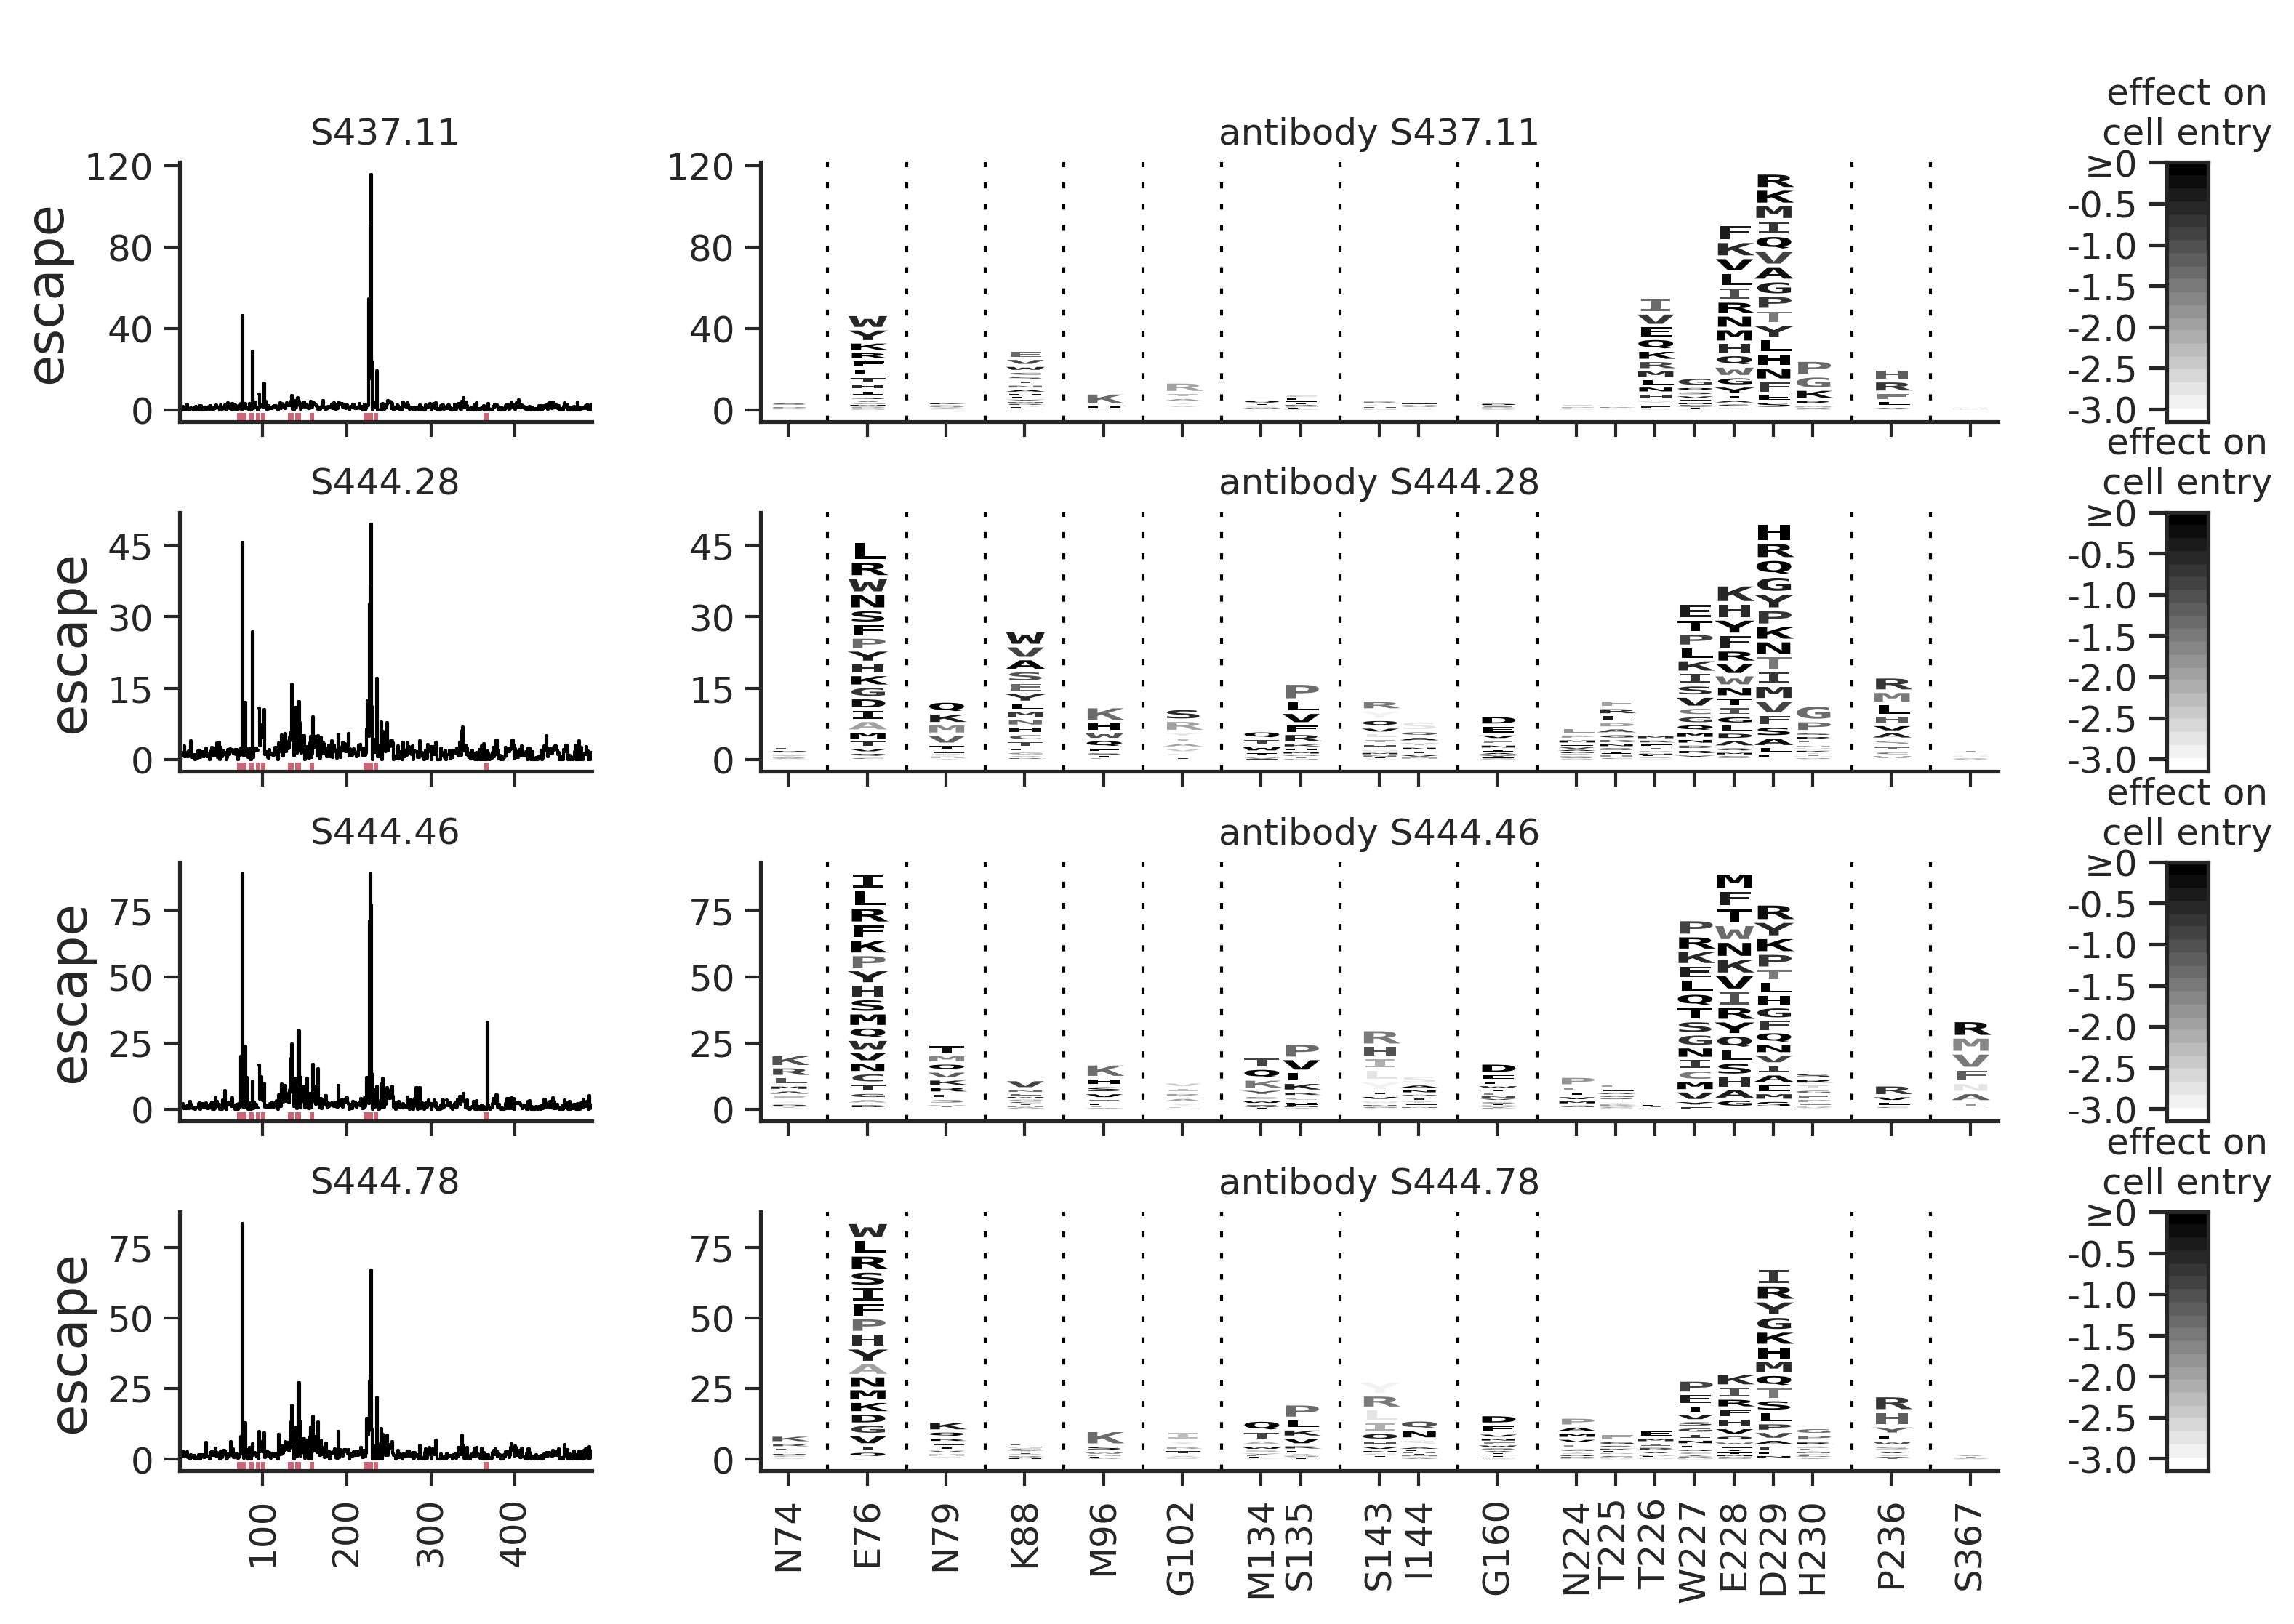

In [6]:
# Flatten list of escape sites
GPC_A_escape_sites = [x for xs in GPC_A_akin_escape_sites for x in xs]

# Combined top sites from each antibody
sites_to_show = list(set(GPC_A_escape_sites))
print("Escape sites to show for GPC-A antibodies")
print(sites_to_show)

# Set figure size and subplots
fig, axes = plt.subplots(
    4, 
    3, 
    gridspec_kw={"width_ratios":[1,3,0.1]},
    figsize=(12, 12), 
    sharex="col",
)

# Adjust spacing of subplots
fig.subplots_adjust(
    wspace=0.3, 
    hspace=0.35,
    top=0.8,
    bottom=0.3,
)

for index,antibody in enumerate(GPC_A_akin_antibodies):
    get_filtered_csv_and_logo_plot(
        antibody,
        func_scores,
        times_seen,
        cell_entry_default,
        n_selections,
        frac_models,
        floor = True,
        sites = sites_to_show,
        ax = axes[index]
    )

# Make output dir if doesn't exist
if not os.path.exists(escape_plots_dir):
    os.mkdir(escape_plots_dir)
    
# Save figure    
fig.savefig(escape_plots_dir + "GPC-A_antibodies_escape_plot.svg")

Get filtered CSV for functional effects

In [7]:
# Read CSV file
func_scores = pd.read_csv(func_scores)

# Filter for minimum selections, times seen
func_scores = (
    func_scores.loc[
        (
            (func_scores["n_selections"] >= n_selections)
            &
            (func_scores["times_seen"] >= times_seen)
        )
        |
        (func_scores["wildtype"] == func_scores["mutant"])
    ]
    .drop(columns=[
        "effect_std",
        "times_seen",
        "n_selections",
    ])
    .reset_index(drop=True)
)

# Save CSV file
func_scores.to_csv(filtered_func_scores, index=False)